<a href="https://colab.research.google.com/github/jmlDC/MediaBias-Thesis22-23/blob/PostAnnotation/Notebooks/Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [1]:
!pip install pyLDAvis -qq
!pip install -U jax -qq
!pip install -U gensim -qq
!pip install spacy -qq
!pip install matplotlib -qq
!pip install seaborn -qq
!python -m spacy download en_core_web_md -qq
!pip install --upgrade numpy -qq
!pip install --upgrade google-colab numba tensorflow -qq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.1.1 which is incompatible.
2023-09-22 01:13:07.011784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 01:13:08.278329: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 12.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This beh

# Import


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
import seaborn as sns
sns.set()
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook() # Visualise inside a notebook
import en_core_web_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

/usr/local/lib/python3.10/dist-packages/google/rpc/__init__.py:20: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.rpc')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  pkg_resources.declare_namespace(__name__)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Mounting Gdrive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dir  = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/"
dir_actual = "/content/drive/MyDrive/THESIS-MS/MediaBias-Thesis22-23/dataset/annotators raw CSV/Actual/"

# Dataset prep

In [7]:
mfc = pd.read_csv(f'{dir}dataset/Extracted-News-May5-7/MFC_prepared.csv', usecols=["code_frames", "annotations"], header=0)
mfc.rename(columns = {'annotations':'Text'}, inplace = True)

mfc

,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
46794,11.0,Smoking is becoming a social taboo
46795,5.0,Nor does it aid lawyers seeking novel ways to...
46796,15.0,'Ashes to Ashes'
46797,15.0,SMOKE SCREEN IS SEEN BEHIND THE SMOKELESS


In [8]:
ph = pd.read_csv(f'{dir_actual}agreed-PHdataset.csv')
ph.rename(columns = {'Majority-Frame':'code_frames'}, inplace = True)

code_frame_dict_1 = {'1. Economic': 1,
                   '2. Capacity and Resources':2,
                   '3. Morality':3,
                   '4. Fairness and Equality':4,
                   '5. Constitutionality and Jurisprudence':5,
                   '6. Policy Prescription and Evaluation':6,
                   '7. Law and Order, Crime and Justice':7,
                   '8. Security and Defense':8,
                   '9. Health and Safety':9,
                   '10. Quality of Life':10,
                   '11. Cultural Identity':11,
                   '12. Public Opinion':12,
                   '13. Political':13,
                   '14. External Regulation and Reputation':14,
                   '15. Other':15
 }

ph['code_frames'] = ph.code_frames.replace(code_frame_dict_1)


ph

,Text,code_frames
0,Dumagat-Remontados opposed to Kaliwa Dam urge ...,4
1,The number of Filipinos against changing the C...,12
2,Jinggoy Estrada calls ICC probers 'white monke...,13
3,President Ferdinand “Bongbong” Marcos Jr. has ...,13
4,The Department of Health (DOH) on Thursday mon...,9
...,...,...
12288,PH diplomat tells China not to question PH-US ...,14
12289,Philippine Ambassador to the United States Jos...,14
12290,China enjoins Asian countries to uphold ‘strat...,14
12291,China wants countries in Asia to “uphold strat...,14


In [9]:
all = pd.concat([mfc, ph], axis=0)

In [10]:
all.dropna()

,code_frames,Text
0,10.0,Immigrants without HOPE need help entering col...
1,5.0,"But in the eyes of the law, he is an illegal i..."
2,15.0,"Reaction to Tancredo, Lamm as predicted"
3,13.0,"That, said the congressman, is what always hap..."
4,1.0,"$50,000 per entry"
...,...,...
12288,14.0,PH diplomat tells China not to question PH-US ...
12289,14.0,Philippine Ambassador to the United States Jos...
12290,14.0,China enjoins Asian countries to uphold ‘strat...
12291,14.0,China wants countries in Asia to “uphold strat...


In [11]:
# https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

# ALL

In [ ]:
import spacy

# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
tokens = []

# Assuming 'all' is a DataFrame containing the 'Text' column
for doc in nlp.pipe(all['Text']):
    proj_tok = [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    tokens.append(proj_tok)

# Display the tokens
print(tokens)


In [ ]:
# Add tokens to new column
all['tokens'] = tokens
all['tokens']

In [ ]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(all['tokens'])
print(dictionary.token2id)

In [ ]:
# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in all['tokens']]

In [ ]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

In [ ]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = all['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [ ]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

In [ ]:
#Print topics
lda_model.print_topics(-1)

# Where does a text belong to
lda_model[corpus][0]
all['Text'][0]

# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)



In [ ]:
# Save the report
pyLDAvis.save_html(lda_display, f'{dir_actual}lda-index.html')

# PH

In [27]:
from itertools import islice

# Function to display a summary of trigrams
def display_trigram_summary(trigrams):
    summary = list(islice(trigrams, 5))  # Display the first 5 trigrams
    print("Trigram Summary:", summary)


In [35]:
import spacy
from nltk.util import ngrams


# Load the spaCy language model
nlp = spacy.load('en_core_web_sm')

removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE', 'NUM', 'SYM']
tokens = []

# Lemmatize then n-gram
for doc in nlp.pipe(ph['Text']):
    proj_tok = [token.lemma_.lower() for token in doc if token.pos_ not in removal and not token.is_stop and token.is_alpha]
    trigrams = list(ngrams(proj_tok, 3))

    # Convert each trigram tuple to a string representation
    trigrams_strings = [' '.join(trigram) for trigram in trigrams]

    # Append the string representation of trigrams to the 'tokens' list
    tokens.append(trigrams_strings)

    # Display a summary of trigrams for each document
    display_trigram_summary(trigrams_strings)





Streaming output truncated to the last 5000 lines.
Trigram Summary: ['remulla doj look', 'doj look red', 'look red flag', 'red flag pattern', 'flag pattern drug']
Trigram Summary: ['manila philippines congress', 'philippines congress seniority', 'congress seniority require', 'seniority require year', 'require year experience']
Trigram Summary: ['marcos want presidential', 'want presidential access', 'presidential access west', 'access west philippine', 'west philippine sea']
Trigram Summary: ['day voter registration', 'voter registration barangay', 'registration barangay poll', 'barangay poll draw', 'poll draw sizable']
Trigram Summary: ['manila philippines heavy', 'philippines heavy hang', 'heavy hang air', 'hang air quezon', 'air quezon city']
Trigram Summary: ['deped probe cavite', 'probe cavite teacher', 'cavite teacher alleged', 'teacher alleged sex', 'alleged sex abuse']
Trigram Summary: ['philippines envoy band', 'envoy band support', 'band support ukraine', 'support ukraine ind

In [36]:
# Add tokens to new column
ph['tokens'] = tokens
ph['tokens']

0        [dumagat remontados oppose, remontados oppose ...
1        [number filipinos change, filipinos change con...
2        [jinggoy estrada call, estrada call icc, call ...
3        [president ferdinand bongbong, ferdinand bongb...
4        [department health doh, health doh thursday, d...
                               ...                        
12288    [ph diplomat tell, diplomat tell china, tell c...
12289    [philippine ambassador united, ambassador unit...
12290    [china enjoin asian, enjoin asian country, asi...
12291    [china want country, want country asia, countr...
12292    [public tell remember, tell remember honor, re...
Name: tokens, Length: 12293, dtype: object

In [37]:
# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(ph['tokens'])
print(dictionary.token2id)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [38]:
# Filter dictionary
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in ph['tokens']]

In [39]:
# LDA model building
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

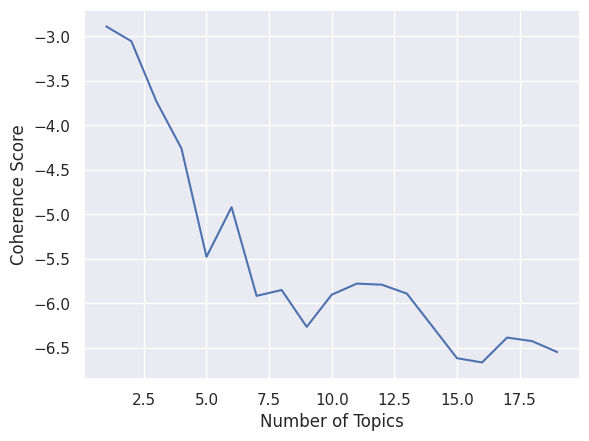

In [ ]:
# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()

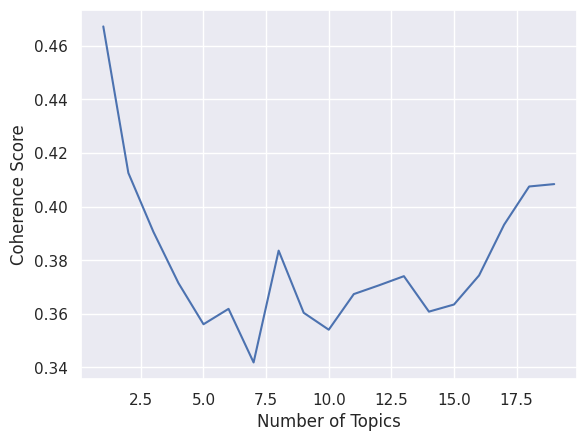

In [ ]:
# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
   lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
   cm = CoherenceModel(model=lda_model, texts = ph['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
   topics.append(i)
   score.append(cm.get_coherence())
_=plt.plot(topics, score)
_=plt.xlabel('Number of Topics')
_=plt.ylabel('Coherence Score')
plt.show()


In [ ]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=5, workers = 4, passes=100)

In [ ]:
#Print topics
lda_model.print_topics(-1)

[(0,
  '0.036*"manila" + 0.025*"philippines" + 0.016*"negros" + 0.016*"duterte" + 0.015*"say" + 0.015*"oriental" + 0.014*"president" + 0.012*"degamo" + 0.011*"commission" + 0.009*"bi"'),
 (1,
  '0.031*"house" + 0.029*"manila" + 0.024*"say" + 0.016*"bill" + 0.015*"senate" + 0.013*"weather" + 0.013*"rain" + 0.012*"senator" + 0.012*"seek" + 0.011*"country"'),
 (2,
  '0.059*"marcos" + 0.038*"philippines" + 0.037*"president" + 0.036*"manila" + 0.035*"ferdinand" + 0.020*"ph" + 0.017*"say" + 0.016*"china" + 0.014*"philippine" + 0.013*"united"'),
 (3,
  '0.032*"manila" + 0.027*"police" + 0.021*"pnp" + 0.021*"national" + 0.018*"philippine" + 0.018*"court" + 0.016*"drug" + 0.014*"chief" + 0.013*"case" + 0.012*"philippines"'),
 (4,
  '0.040*"manila" + 0.027*"department" + 0.018*"health" + 0.016*"government" + 0.015*"doh" + 0.015*"say" + 0.014*"philippines" + 0.014*"philippine" + 0.012*"water" + 0.011*"oil"')]

In [ ]:
# Where does a text belong to
lda_model[corpus][0]
ph['Text'][0]

'Dumagat-Remontados opposed to Kaliwa Dam urge NCIP to defend their rights'

In [ ]:
# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

In [ ]:
# Save the report
pyLDAvis.save_html(lda_display, f'{dir_actual}lda-ph-index.html')

In [ ]:
from IPython.display import display, HTML

# Path to the uploaded HTML file
html_file_path = f'{dir_actual}lda-ph-index.html'

# Read the HTML file and display it
with open(html_file_path, 'r') as file:
    html_contents = file.read()
    display(HTML(html_contents))


Topic 18


In [ ]:
lda_model_18 = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=18, workers = 4, passes=100)

In [ ]:
#Print topics
lda_model_18.print_topics(-1)

[(0,
  '0.051*"week" + 0.041*"bi" + 0.037*"want" + 0.035*"holy" + 0.031*"immigration" + 0.026*"solon" + 0.025*"bureau" + 0.023*"ex" + 0.023*"manila" + 0.021*"human"'),
 (1,
  '0.056*"manila" + 0.037*"rain" + 0.031*"weather" + 0.025*"say" + 0.021*"shower" + 0.020*"part" + 0.019*"transportation" + 0.018*"luzon" + 0.017*"public" + 0.017*"experience"'),
 (2,
  '0.051*"case" + 0.050*"doh" + 0.047*"health" + 0.037*"new" + 0.033*"department" + 0.033*"philippines" + 0.028*"area" + 0.027*"say" + 0.022*"country" + 0.019*"manila"'),
 (3,
  '0.030*"manila" + 0.028*"government" + 0.027*"say" + 0.022*"water" + 0.021*"department" + 0.020*"food" + 0.018*"country" + 0.017*"use" + 0.017*"address" + 0.017*"da"'),
 (4,
  '0.082*"house" + 0.061*"senate" + 0.048*"seek" + 0.047*"bill" + 0.042*"senator" + 0.025*"representatives" + 0.021*"approve" + 0.020*"propose" + 0.020*"push" + 0.018*"leader"'),
 (5,
  '0.088*"police" + 0.061*"pnp" + 0.059*"national" + 0.048*"philippine" + 0.041*"manila" + 0.037*"drug" + 0

In [ ]:
# Where does a text belong to
lda_model_18[corpus][0]
ph['Text'][0]

'Dumagat-Remontados opposed to Kaliwa Dam urge NCIP to defend their rights'

In [ ]:
# Visualize topics
lda_display = pyLDAvis.gensim_models.prepare(lda_model_18, corpus, dictionary)
pyLDAvis.display(lda_display)

In [ ]:
# Save the report
pyLDAvis.save_html(lda_display, f'{dir_actual}lda-ph-index_18.html')